In [4]:
# 필요한 라이브러리 임포트
import base64
import requests
from IPython.display import display, Image
from dotenv import load_dotenv
import os
import openai

# langchain 관련 라이브러리
from langchain.chat_models import ChatOpenAI


In [5]:
# .env 파일에서 API 키 로드
load_dotenv()

# OpenAI API 키 설정
openai.api_key = os.getenv("OPENAI_API_KEY")


In [6]:
class MultiModal:
    def __init__(self, model, system_prompt=None, user_prompt=None):
        self.model = model
        self.system_prompt = system_prompt
        self.user_prompt = user_prompt
        self.init_prompt()

    def init_prompt(self):
        if self.system_prompt is None:
            self.system_prompt = "You are a helpful assistant who helps users to write a report related to images in Korean."
        if self.user_prompt is None:
            self.user_prompt = "Explain the images as an alternative text in Korean."

    # 이미지를 base64로 인코딩하는 함수 (URL)
    def encode_image_from_url(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            image_content = response.content
            if url.lower().endswith((".jpg", ".jpeg")):
                mime_type = "image/jpeg"
            elif url.lower().endswith(".png"):
                mime_type = "image/png"
            else:
                mime_type = "image/unknown"
            return f"data:{mime_type};base64,{base64.b64encode(image_content).decode('utf-8')}"
        else:
            raise Exception("Failed to download image")

    # 이미지를 base64로 인코딩하는 함수 (파일)
    def encode_image_from_file(self, file_path):
        with open(file_path, "rb") as image_file:
            image_content = image_file.read()
            file_ext = os.path.splitext(file_path)[1].lower()
            if file_ext in [".jpg", ".jpeg"]:
                mime_type = "image/jpeg"
            elif file_ext == ".png":
                mime_type = "image/png"
            else:
                mime_type = "image/unknown"
            return f"data:{mime_type};base64,{base64.b64encode(image_content).decode('utf-8')}"

    # 이미지 경로에 따라 적절한 함수를 호출하는 함수
    def encode_image(self, image_path):
        if image_path.startswith("http://") or image_path.startswith("https://"):
            return self.encode_image_from_url(image_path)
        else:
            return self.encode_image_from_file(image_path)

    def display_image(self, encoded_image):
        display(Image(url=encoded_image))

    def create_messages(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        encoded_image = self.encode_image(image_url)
        if display_image:
            self.display_image(encoded_image)

        system_prompt = (
            system_prompt if system_prompt is not None else self.system_prompt
        )

        user_prompt = user_prompt if user_prompt is not None else self.user_prompt

        # 인코딩된 이미지를 사용하여 다른 처리를 수행할 수 있습니다.
        messages = [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"{encoded_image}"},
                    },
                ],
            },
        ]
        return messages

    def invoke(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        messages = self.create_messages(
            image_url, system_prompt, user_prompt, display_image
        )
        response = self.model.invoke(messages)
        return response.content

    def batch(
        self,
        image_urls: list[str],
        system_prompts: list[str] = [],
        user_prompts: list[str] = [],
        display_image=False,
    ):
        messages = []
        for image_url, system_prompt, user_prompt in zip(
            image_urls, system_prompts, user_prompts
        ):
            message = self.create_messages(
                image_url, system_prompt, user_prompt, display_image
            )
            messages.append(message)
        response = self.model.batch(messages)
        return [r.content for r in response]

    def stream(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        messages = self.create_messages(
            image_url, system_prompt, user_prompt, display_image
        )
        response = self.model.stream(messages)
        return response


/var/folders/zk/p59k4t_16mlgf68b5hxclv6m0000gn/T/ipykernel_23028/3172021063.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(



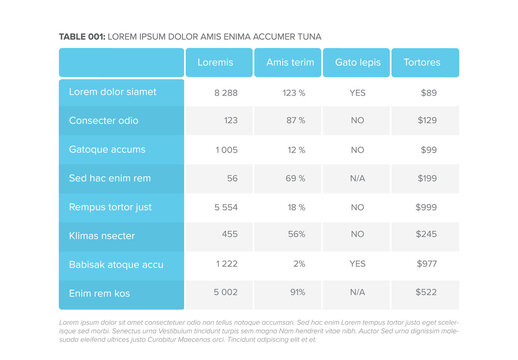

이 이미지는 표 형식의 데이터 테이블을 보여줍니다. 표의 제목은 "TABLE 001: LOREM IPSUM DOLOR AMIS ENIMA ACCUMER TUNA"입니다. 표는 다섯 개의 열로 구성되어 있으며, 각 열의 제목은 "Loremis", "Amis terim", "Gáto lepis", "Tortores"입니다. 각 행에는 다양한 데이터가 포함되어 있으며, 숫자, 백분율, "YES" 또는 "NO"와 같은 텍스트, 그리고 달러($) 기호가 포함된 금액이 표시됩니다. 표 아래에는 작은 글씨로 설명 텍스트가 있습니다.


In [7]:
# 필요한 라이브러리를 먼저 임포트합니다.
from IPython.display import display

# 멀티모달 객체를 생성할 때 사용할 LLM 객체를 정의합니다.
# temperature와 모델명을 지정하여 생성합니다.
llm = ChatOpenAI(
    temperature=0.1,  # 창의성 조정
    model_name="gpt-4o",  # 모델명 설정
)

# 멀티모달 객체 생성
multimodal_llm = MultiModal(llm)

# 테스트할 이미지 URL
IMAGE_URL = "https://t3.ftcdn.net/jpg/03/77/33/96/360_F_377339633_Rtv9I77sSmSNcev8bEcnVxTHrXB4nRJ5.jpg"

# 이미지 설명을 생성하고 실시간으로 응답을 확인하는 코드
def stream_response(response_stream):
    for token in response_stream:
        print(token, end='')  # 실시간으로 토큰을 출력하여 확인

# 전체 응답을 한 번에 받는 방식
answer = multimodal_llm.invoke(IMAGE_URL)

# 응답 출력
print(answer)


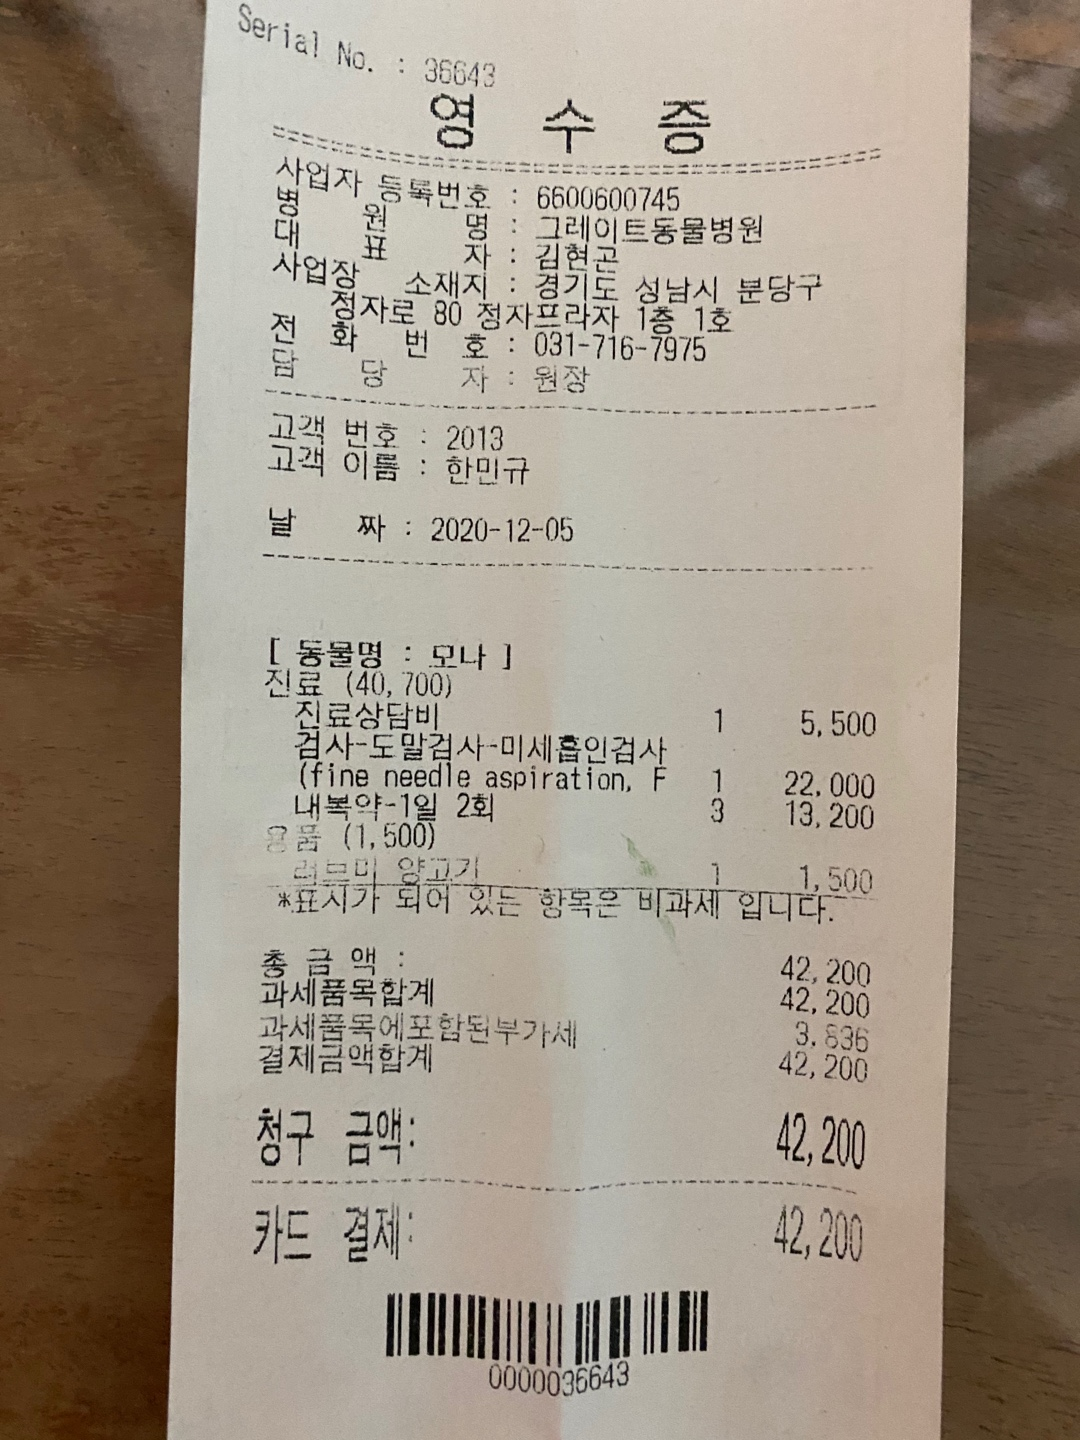

이 이미지는 동물병원에서 발급된 영수증입니다. 상단에는 사업자 등록번호, 병원명(그레이트동물병원), 대표자 이름, 주소, 전화번호 등의 정보가 있습니다. 고객 정보로는 고객 번호와 이름이 기재되어 있으며, 날짜는 2020년 12월 5일입니다.

영수증에는 진료받은 동물의 이름(모나)과 진료 항목들이 나열되어 있습니다. 항목으로는 진료비, 검사비(도말검사 및 미세흡인검사), 내복약 등이 포함되어 있으며, 각각의 금액이 표시되어 있습니다. 총 금액은 42,200원이며, 카드 결제로 이루어졌습니다. 하단에는 바코드가 인쇄되어 있습니다.


In [8]:
IMAGE_PATH_FROM_FILE = "images/test.jpg"

# 전체 응답을 한 번에 받는 방식
answer = multimodal_llm.invoke(IMAGE_PATH_FROM_FILE)

# 응답 출력
print(answer)
